<a href="https://colab.research.google.com/github/daniilstv/computer_vision/blob/master/hw8_danill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Реализовать синтезирование лиц из LFW с помощью DCGAN


Выполнено с использованием https://github.com/Nickel-nc/GU_Deep_Learning_In_Computer_Vision

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from math import sqrt as sq
import tensorflow as tf
import numpy as np
import collections
import os
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     BatchNormalization, Flatten, Dense, Reshape, 
                                     Conv2DTranspose, Activation, LeakyReLU, Dropout)

In [44]:
train, DatasetInfo = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train')

In [45]:
train
# plt.imshow(train)

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [46]:
DatasetInfo

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [47]:
N_SHOW = 9 # Количество выводимых изображений
INPUT_DIM = 100 # Размерность латентного вектора
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16  # размер серии генерируемых изображений
BATCH_SIZE = HALF_BATCH_SIZE * 2  # размер серии с учетом реальных изображений
LEARNING_RATE = 0.001

In [48]:
# Принимает на вход объект tensorflow OptionsDataset и выводит матрицу изображений с метками с заданным размером
def plot_images_grid(data, n):
    samples = data.take(n)
    plt.figure(figsize=(16,12))
    
    # В данном датасете [0] элементом являются метки класса, [1] - само изображение
    for i, sample in enumerate(samples):
        plt.subplot(sq(n)+1,sq(n),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sample[1])
        plt.xlabel(sample[0].numpy().decode().replace("_", " "))
    plt.show()

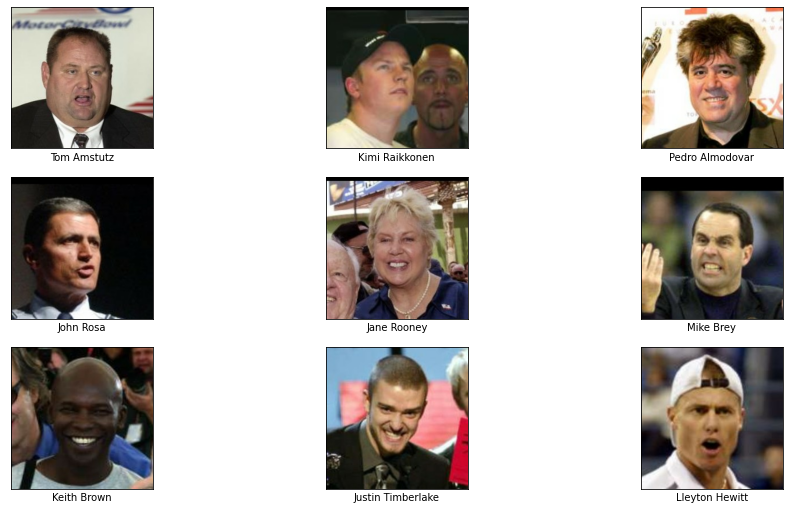

In [49]:
plot_images_grid(train, N_SHOW)

In [52]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224]) # корректировка размерности входа в модель
    return label, (tf.cast(img, tf.float32) - 127.5) / 127.5  # стандартизация изображения

train = train.repeat(NUM_EPOCHS)
train = train.batch(HALF_BATCH_SIZE, drop_remainder=True)
train = train.map(prepare)

In [53]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

# Функция выводаа изображений во время обучения
def plot_images(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [54]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.5356; G Loss: 0.5062


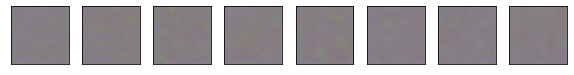

[Step 1000] D Loss: 34.2153; G Loss: 90.8971


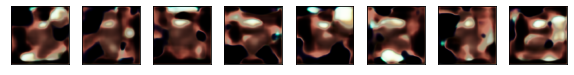

[Step 2000] D Loss: 0.2369; G Loss: 18.1203


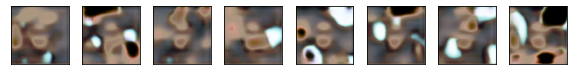

In [ ]:
for step, (_, true_images) in enumerate(train):
    
    # Шаг тренеровки дискриминатора
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Шаг тренеровки генератора
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Вывод промежуточных результатов
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

In [ ]:
# Сохранение весов в  HDF5 файл
generator.save('./models/generator.h5')
discriminator.save('./models/discriminator.h5')

generator.summary()
discriminator.summary()

In [ ]:
noise = np.random.normal(0, 1, (64, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 64)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)